In [1]:
## import needed mods
import pandas as pd, numpy as np, scipy.stats as ss, seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from PIL import Image
from matplotlib import pyplot as plt 
plt.style.use(['tableau-colorblind10'])

%matplotlib inline

In [2]:
## Write needed ftns for analysis
def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [3]:
## set path and bring in genotype data
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
geno_df = pd.read_csv(geno_path)
loci = geno_df.Block.drop_duplicates().index

In [4]:
## View frist 5 rows of chromosome 14 data
geno_df[(geno_df.Chrom=='Chr14')].head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
88605,Chr14,6648,146846.0,1.0,T,G,1,8809,snp,230,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88606,Chr14,15301,89905.0,1.0,CTTTTTTTTTTTAAAAAAAAGGT,CTTTTTTTTTTAAAAAAAAAGGT,1,6238,indel,348,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88607,Chr14,24175,156761.0,1.0,C,T,1,9515,snp,531,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88608,Chr14,28073,139655.0,1.0,CA,CG,1,8586,indel,619,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88609,Chr14,28198,139875.0,1.0,TTACA,TTACG,1,8498,indel,624,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5]:
## Set gff path and bring in data
gff_path = '../DATA/xl280genome.gff3.csv.gz'
gff = pd.read_csv(gff_path,index_col=0)

## Check data for gene CNN01270 ie RIC8
gff[(gff.id == 'CNN01270')]

,type,gene,start,end,strand,contig,phase,attribute,description,id
53405,gene,CNN01270,386833,389699,+,Chr14,.,ID=CNN01270;description=hypothetical protein,hypothetical protein,CNN01270


In [6]:
## View variants within RIC8
geno_df[(geno_df.Chrom=='Chr14') & 
        (geno_df.Pos>=386833) & 
        (geno_df.Pos<=389699)].head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
90523,Chr14,386898,117375.0,1.0,G,A,1,7300,snp,10980,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90524,Chr14,386995,131484.0,1.0,T,A,1,8331,snp,10984,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90525,Chr14,387211,157752.0,1.0,T,G,1,9574,snp,10990,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90526,Chr14,387317,163742.0,1.0,A,G,1,9883,snp,10991,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90527,Chr14,387368,166211.0,1.0,G,T,1,9840,snp,10992,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [7]:
## Define chromosomes
chrlist = sorted(geno_df.Chrom.unique())
len(chrlist)

14

In [8]:
## Gather the length of each chromosome
clens = [geno_df[(geno_df.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]

In [9]:
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [10]:
## Set path for phenotype data
file_path = '../DATA/PHENOTYPE/H2O2/H2O2_scores.csv.gz'

In [11]:
## Bring in H2O2 data check shape
h2O2 = pd.read_csv(file_path)
h2O2.shape

(480, 9)

In [12]:
## Check plate names
sorted(h2O2.Plate.unique())

[1, 2]

In [13]:
## view first few rows
h2O2.head()

,Row,Column,Plate,Strain,Scoredm,Scorelh,Plate_name,Replicate_name,Replicate
0,e,7,2,SS-A837,3.0,3.0,qtl2a,a,0
1,e,7,2,SS-A837,2.0,2.0,qtl2b,b,1
2,e,7,2,SS-A837,2.0,2.0,qtl2c,c,2
3,e,7,2,SS-A837,2.0,2.0,qtl2d,d,3
4,b,2,2,SS-B307,2.0,2.0,qtl2a,a,0


In [14]:
h2O2lh = h2O2[['Row','Column','Plate','Scorelh','Strain','Replicate']].copy()
h2O2lh['Score'] = h2O2lh.Scorelh
h2O2lh.drop('Scorelh',axis=1,inplace=True)
h2O2lh['Marker'] = 'LH'

In [15]:
h2O2dm = h2O2[['Row','Column','Plate','Scoredm','Strain','Replicate']].copy()
h2O2dm['Score'] = h2O2dm.Scoredm
h2O2dm.drop('Scoredm',axis=1,inplace=True)
h2O2dm['Marker'] = 'DM'

In [16]:
dmm = h2O2dm.dropna().groupby('Strain').agg(np.median).Score
lhm = h2O2lh.dropna().groupby('Strain').agg(np.median).Score

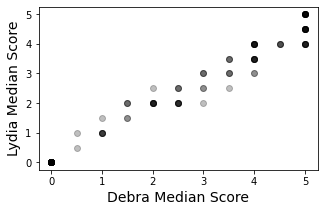

In [17]:
## Compare old plates and scorer H2O2 phenotypes
fig,ax = plt.subplots(1,1,figsize=(5,3),sharex=True,sharey=True)
plt.plot(dmm.values,
         lhm.values,'ko',alpha=0.25);
plt.xlabel('Debra Median Score',fontsize=14);
plt.ylabel('Lydia Median Score',fontsize=14);

#plt.savefig('/home/croth/Desktop/H2O2_median_growth_Debra_vs_Lydia_old_new.png',
#           dpi=100,bbox_inches='tight');

In [18]:
## Check rank corr with older plates
ss.spearmanr(dmm.values,lhm.values)
## B/c the old plates seem to introduce more variation
## we will droped these from analysis

SpearmanrResult(correlation=0.9803019694515043, pvalue=2.870340990903693e-84)

In [19]:
dm_scores = [a[1].Score.values 
              for a in h2O2dm.sort_values('Strain').groupby('Replicate')]
dm_ranks = []
for i, h in enumerate(dm_scores):
    for j, k in enumerate(dm_scores):
        if i != j and i >= j:
            sr = ss.spearmanr(h,k)
            print(i,j,sr);
            dm_ranks.append((i,j,sr[0]))
            
dm_ranks = pd.DataFrame(dm_ranks,columns = ['Rep1','Rep2','Rank'])
dm_ranks.Rank.mean()

1 0 SpearmanrResult(correlation=0.8824224754673616, pvalue=1.8872215723743576e-40)
2 0 SpearmanrResult(correlation=0.8382735261831195, pvalue=7.218697086829466e-33)
2 1 SpearmanrResult(correlation=0.8798313289699106, pvalue=6.31434020507341e-40)
3 0 SpearmanrResult(correlation=0.8395813615484946, pvalue=4.655534474536432e-33)
3 1 SpearmanrResult(correlation=0.9150979272055131, pvalue=2.2822274367867583e-48)
3 2 SpearmanrResult(correlation=0.8775230954417405, pvalue=1.8091561277997454e-39)


0.8721216191360234

In [20]:
lh_scores = [a[1].Score.values 
              for a in h2O2lh.sort_values('Strain').groupby('Replicate')]
lh_ranks = []
for i, h in enumerate(lh_scores):
    for j, k in enumerate(lh_scores):
        if i != j and i >= j:
            sr = ss.spearmanr(h,k)
            print(i,j,sr);
            lh_ranks.append((i,j,sr[0]))
            
lh_ranks = pd.DataFrame(lh_ranks,columns = ['Rep1','Rep2','Rank'])
lh_ranks.Rank.mean()

1 0 SpearmanrResult(correlation=0.8673541006750937, pvalue=1.4689560887082027e-37)
2 0 SpearmanrResult(correlation=0.7916624375240877, pvalue=5.1738200224357864e-27)
2 1 SpearmanrResult(correlation=0.8516224589697897, pvalue=6.757519002247173e-35)
3 0 SpearmanrResult(correlation=0.8637936056338018, pvalue=6.288826185844876e-37)
3 1 SpearmanrResult(correlation=0.9065864091874128, pvalue=4.968393213371251e-46)
3 2 SpearmanrResult(correlation=0.8692193662509846, pvalue=6.74225361688571e-38)


0.858373063040195

In [21]:
## Gather H2O2 scores across scores 
## Do not use older plates
h2O2L = pd.concat([h2O2dm,
                   h2O2lh],
                  axis=0,sort=True)

## Drop missing data (shouldn't be any)
h2O2L.dropna(inplace=True)

## Check tail of df
h2O2L.tail()

,Column,Marker,Plate,Replicate,Row,Score,Strain
475,6,LH,2,3,e,4.0,XL280a
476,5,LH,2,0,e,5.0,XL280alpha
477,5,LH,2,1,e,4.0,XL280alpha
478,5,LH,2,2,e,4.0,XL280alpha
479,5,LH,2,3,e,3.0,XL280alpha


In [22]:
## Take data for which we have genotype data for
h2O2Ls = h2O2L[(h2O2L.Strain.isin(geno_df.columns))]

## Check shape should be 104
h2O2Ls.Strain.unique().shape

(104,)

In [23]:
## Gather unique segregants
segs = [a[0] for a in h2O2Ls.groupby('Strain')]

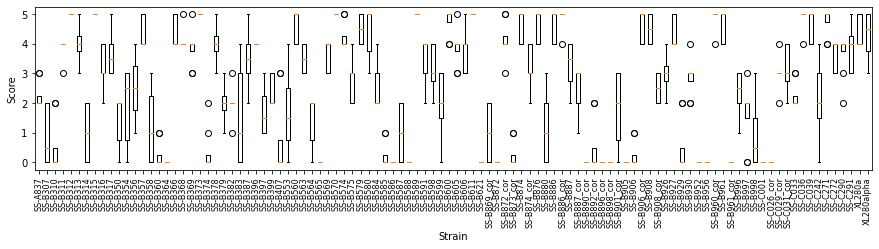

In [24]:
## View scores across segregants
fig,ax = plt.subplots(1,1,figsize=(15,3))
plt.boxplot([a[1]['Score'].values 
             for a in h2O2Ls.groupby('Strain')]);

plt.xticks(np.arange(len(segs))+1,segs
           ,rotation=90,fontsize=8);
plt.xlabel('Strain');plt.ylabel('Score');

In [25]:
## Take median H2O2 growth scores
medh2o2 = h2O2Ls.groupby('Strain').agg(np.median)
medh2o2.head()

,Column,Plate,Replicate,Score
Strain,,,,
SS-A837,7.0,2.0,1.5,2.0
SS-B307,2.0,2.0,1.5,0.5
SS-B310,4.0,2.0,1.5,0.0
SS-B311,5.0,2.0,1.5,4.0
SS-B312,6.0,2.0,1.5,5.0


In [26]:
## Write labels
_431label = r'$431\mathrm{\alpha}$'
_xl280alabel='XL280'+r'$\bf{a}$'
_xl280alphlabel = r'XL280$\mathrm{\alpha}$'
alpha_label = r'$\mathrm{\alpha}$ = 0.05'

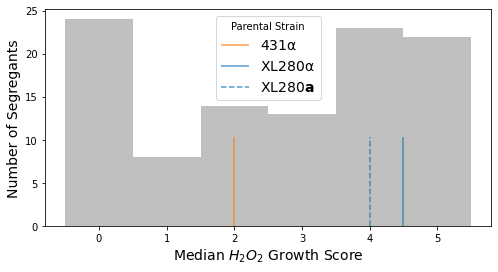

In [27]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
plt.hist(medh2o2.Score.values,color='grey',alpha=0.5,
         bins=np.arange(7)-0.5);
plt.xlabel('Median $H_{2}O_{2}$ Growth Score',fontsize=14);
plt.ylabel('Number of Segregants',fontsize=14);
plt.vlines(medh2o2.T['SS-A837'].T.Score,0,len(segs)/10,
           alpha=0.75,color='tab:orange',label=_431label);
plt.vlines(medh2o2.T['XL280alpha'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='-',
           color='tab:blue',label=_xl280alphlabel);
plt.vlines(medh2o2.T['XL280a'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='--',
           color='tab:blue',label=_xl280alabel);
plt.legend(title='Parental Strain',fontsize=14);

In [28]:
len(segs)

104

In [29]:
test = geno_df[segs].drop_duplicates()
test.shape

(2777, 104)

In [30]:
test['Pval'] = test.apply(association_logPval,
                          args=[medh2o2.T[segs].T.Score],axis=1)
pvaldf = geno_df.merge(test)

In [31]:
pvaldf[(pvaldf.Chrom=='Chr12')].Pval.max()

4.518186729935608

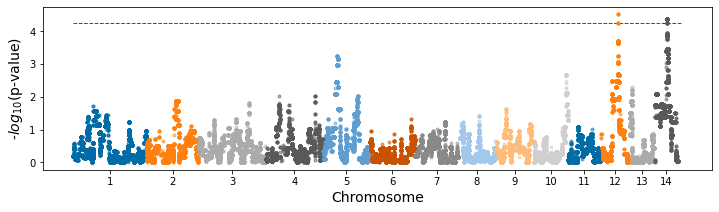

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(chrlist):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',alpha=0.5);

plt.hlines(4.2589,0,19*(10**6),
           linestyle='--',alpha=0.7,
           linewidth=1,label=alpha_label,color='k')


plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('-$log_{10}$(p-value)',fontsize=14);

In [33]:
ch02ix = pvaldf[(pvaldf.Chrom=='Chr02')].Pval.idxmax()

In [34]:
ch12ix = pvaldf[(pvaldf.Chrom=='Chr12')].Pval.idxmax()
ch14ix = pvaldf[(pvaldf.Chrom=='Chr14')].Pval.idxmax()

In [35]:
medh2o2['Chr02'] = np.array(pvaldf.T[ch02ix][segs],dtype=float)
medh2o2['Chr12'] = np.array(pvaldf.T[ch12ix][segs],dtype=float)
medh2o2['Chr14'] = np.array(pvaldf.T[ch14ix][segs],dtype=float)

In [36]:
ssk2 = pd.read_csv('../DATA/GENOTYPE/CNL05560.csv.gz',index_col=0)
ssk1 = pd.read_csv('../DATA/GENOTYPE/CNB03090.csv.gz',index_col=0)
ric8 = pd.read_csv('../DATA/GENOTYPE/CNN01270.csv.gz',index_col=0)

In [37]:
medh2o2['SSK2'] = pvaldf[(pvaldf.Chrom=='Chr12') & 
                   (pvaldf.Pos>=ssk2.Start.min()) & 
                       (pvaldf.Pos<=ssk2.End.max())][medh2o2.index].min()

In [38]:
medh2o2['RIC8'] = pvaldf[(pvaldf.Chrom=='Chr14') & 
       (pvaldf.Pos>=ric8.Start.min()) & 
       (pvaldf.Pos<=ric8.End.max())][medh2o2.index].min()

In [39]:
medh2o2.head()

,Column,Plate,Replicate,Score,Chr02,Chr12,Chr14,SSK2,RIC8
Strain,,,,,,,,,
SS-A837,7.0,2.0,1.5,2.0,1.0,1.0,1.0,1.0,1.0
SS-B307,2.0,2.0,1.5,0.5,0.0,0.0,1.0,0.0,1.0
SS-B310,4.0,2.0,1.5,0.0,1.0,0.0,1.0,0.0,1.0
SS-B311,5.0,2.0,1.5,4.0,0.0,1.0,1.0,1.0,1.0
SS-B312,6.0,2.0,1.5,5.0,0.0,1.0,0.0,1.0,0.0


In [40]:
medh2o2.shape

(104, 9)

In [41]:
## Save data out for later use / analysis
medh2o2.to_csv('../DATA/PHENOTYPE/H2O2/H2O2_average_phenotypes.csv.gz',
               index=True)

In [42]:
## Check counds by allele combinations
medh2o2.groupby(['Chr12','Chr14']).count()

Column  Plate  Replicate  Score  Chr02  SSK2  RIC8
Chr12 Chr14                                                    
0.0   0.0        24     24         24     24     24    24    24
      1.0        41     41         41     41     41    41    41
1.0   0.0        26     26         26     26     26    26    26
      1.0        13     13         13     13     13    13    13

In [43]:
## Gather parental data
parents = medh2o2.T[['SS-A837','XL280a']].T[['Score','Chr02']]

In [44]:
## Bring in other needed mods
import statsmodels.formula.api as smf

from matplotlib.gridspec import GridSpec
from PIL import Image


import matplotlib.image as mpimg
plt.style.use(['tableau-colorblind10'])

In [45]:
## Conduct regression analysis on chromosome 12 QTL
qtl12_res = smf.ols('Score~Chr12',data=medh2o2).fit()
qtl12_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     19.07
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           3.03e-05
Time:                        13:10:24   Log-Likelihood:                -202.56
No. Observations:                 104   AIC:                             409.1
Df Residuals:                     102   BIC:                             414.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0231      0.213      9.520      0.000       1.602       2.445
Chr12          1.5154      0.347      4.367      0.000       0.827       2.204
==============================================================================
Omnibus:                       17.698   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.718
Skew:                          -0.013   Prob(JB):                       0.0945
Kurtosis:                       1.957   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
## Conduct regression on chromosome 14 QTL
qtl14_res = smf.ols('Score~Chr14',data=medh2o2).fit()
qtl14_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     18.26
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           4.33e-05
Time:                        13:10:24   Log-Likelihood:                -202.90
No. Observations:                 104   AIC:                             409.8
Df Residuals:                     102   BIC:                             415.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3400      0.243     13.739      0.000       2.858       3.822
Chr14         -1.4419      0.337     -4.274      0.000      -2.111      -0.773
==============================================================================
Omnibus:                       18.236   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.694
Skew:                          -0.246   Prob(JB):                       0.0580
Kurtosis:                       1.965   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
## Test interactive modle
qtl12_14_res = smf.ols('Score~Chr12*Chr14',data=medh2o2).fit()
qtl12_14_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     12.85
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           3.62e-07
Time:                        13:10:24   Log-Likelihood:                -194.52
No. Observations:                 104   AIC:                             397.0
Df Residuals:                     100   BIC:                             407.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.0833      0.327      9.431      0.000       2.435       3.732
Chr12           0.4936      0.453      1.089      0.279      -0.406       1.393
Chr14          -1.6809      0.412     -4.083      0.000      -2.498      -0.864
Chr12:Chr14     1.5655      0.682      2.295      0.024       0.212       2.919
==============================================================================
Omnibus:                        5.771   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                3.512
Skew:                          -0.262   Prob(JB):                        0.173
Kurtosis:                       2.269   Cond. No.                         6.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
## Set chromosome colors
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [49]:
## Conduct permutations
import os
kps = 10000
perms = []
perm_path = '../DATA/PERMUTATIONS/Cden_H2O2_permutations_null.csv.gz'
if not os.path.exists(perm_path):
    while len(perms)<kps:
    
        ran_pval = test[segs].apply(association_logPval,
                                args=[medh2o2.T[np.random.permutation(segs)].T.Score],
                                axis=1).max()
        perms.append(ran_pval)
    pd.DataFrame(perms,columns=['H2O2']).to_csv(perm_path,index=False)
else:
    perms = pd.read_csv(perm_path)['H2O2'].values
    
threshold_95 = np.percentile(perms,95)
threshold_95

4.258910961495085

In [50]:
## gather progeny
F_1 = [s for s in segs if s not in ['XL80a','XL280alpha','SS-A837']]

/home/croth/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


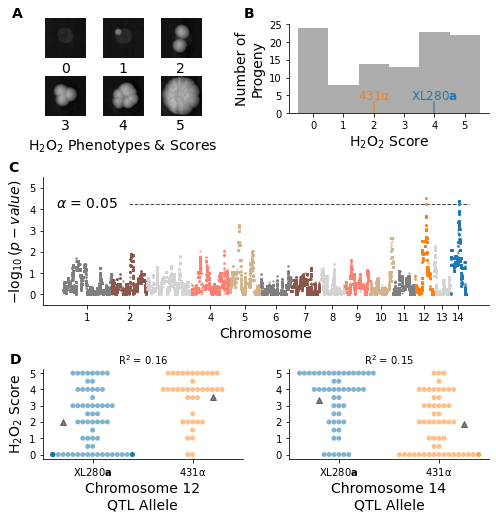

In [51]:
## Make figure 9
fig = plt.figure(figsize=(8,8))
gs = GridSpec(12,4,figure=fig)
ax_fake = fig.add_subplot(gs[:2,:2])
plt.sca(ax_fake)
[ax_fake.spines[s].set_visible(False) for s in ['top','right']]

plt.title(x=-0.125,y=1,label='A',
          fontsize=14,fontweight='bold')
plt.xticks([]);plt.yticks([])

[ax_fake.spines[j].set_visible(False) for j in ['top','bottom','left','right']]

ax_hist = fig.add_subplot(gs[:3,2:])

[ax_hist.spines[s].set_visible(False) for s in ['top','right']]


plt.hist(medh2o2.Score.values,color='grey',alpha=0.65,
         bins=np.arange(7)-0.5);

plt.xlabel('H$_{2}$O$_{2}$ Score',fontsize=14);
plt.xticks([0,1,2,3,4,5])
plt.ylabel('Number of\nProgeny',fontsize=14);
plt.yticks(np.arange(0,35,5))

plt.vlines(medh2o2.T['XL280a'].T.Score,0,3.5,
           alpha=0.75,linestyle='-',
           color='tab:blue')#,label=_xl280alabel);
plt.text(medh2o2.T['XL280a'].T.Score,4,
         _xl280alabel,fontsize=12,
         color='tab:blue',ha='center')

plt.vlines(medh2o2.T['SS-A837'].T.Score,0,3.5,
           alpha=0.75,color='tab:orange')#,label=_431label);
plt.text(medh2o2.T['SS-A837'].T.Score,4,
         _431label,fontsize=12,
         color='tab:orange',ha='center')

plt.title(x=-0.2,y=1,label='B',
          fontsize=14,fontweight='bold')

##### ----------------------------------------------------------###
ax_qtl1 = fig.add_subplot(gs[9:,:2])
[ax_qtl1.spines[s].set_visible(False) for s in ['top','right']]

sns.swarmplot(x='Chr12',y='Score',
              data=medh2o2,alpha=0.5)


plt.plot( [-0.3,1.2] , medh2o2.groupby('Chr12').mean()['Score'].values,
         #medh2o2.T[['SS-A837','XL280a']].T['Score'].values[::-1],
         'k^',alpha=0.5)

plt.ylabel(r'H$_{2}$O$_{2}$ Score',fontsize=14)
plt.yticks(np.arange(6))
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 12\nQTL Allele',fontsize=14)
plt.title(x=-0.135,y=1,label='D',
          fontsize=14,fontweight='bold')
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl12_res.rsquared,2),
        ha='center')
### -------------------------------------------------------------- ###
ax_qtl2 = fig.add_subplot(gs[9:,2:])
[ax_qtl2.spines[s].set_visible(False) for s in ['top','right']]

sns.swarmplot(x='Chr14',y='Score',
              data=medh2o2,alpha=0.5)

plt.plot( [-0.2,1.25] , medh2o2.groupby('Chr14').mean()['Score'].values,
         #medh2o2.T[['SS-A837','XL280a']].T['Score'].values[::-1],
         'k^',alpha=0.5)

plt.yticks(np.arange(6))
plt.ylabel('')
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 14\nQTL Allele',fontsize=14)
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl14_res.rsquared,2),
        ha='center')
### --------------------------- QTL MAPPING --------------------- ###

ax_qtl = fig.add_subplot(gs[4:8,:])

plt.sca(ax_qtl)
plt.title(x=-0.065,y=1,label='C',
          fontsize=14,fontweight='bold')

for c,chrom in enumerate(chrlist):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    
    if chrom == 'Chr12':
        cc = 'tab:orange'
    elif chrom == 'Chr14':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[c%len(chrom_colors)]

    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',alpha=0.5,color=cc,markersize=3);


plt.hlines(threshold_95,chrom_midpts[1],19*(10**6),
           linestyle='--',alpha=0.7,
           linewidth=1,label=alpha_label,color='k')

plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

plt.ylim(-0.5,5.5)
plt.yticks([0,1,2,3,4,5])
##### ------------------------------------------------------ #####
plt.sca(ax_hist)
yw = 0.07
yh = 0.82
yh2 = 0.72
ax0 = fig.add_axes([0.13,yh,yw,yw])
pheno0 = '/home/croth/H2O2_0_crop.png'
pheno0_obj = Image.open(pheno0)
plt.imshow(pheno0_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'0',va='center',ha='center',
         transform=ax0.transAxes,fontsize=14)
plt.axis('off')
#plt.title(x=-2,y=2.35,label='A',
#          fontsize=14,fontweight='bold')

ax1 = fig.add_axes([0.23,yh,yw,yw])
pheno1 = '/home/croth/H2O2_1_crop.png'
pheno1_obj = Image.open(pheno1)
plt.imshow(pheno1_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'1',va='center',ha='center',
         transform=ax1.transAxes,fontsize=14)
plt.axis('off')
plt.title(x=0.5,y=-2.4,
          label=r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',
         fontsize=14)
#plt.xlabel(r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',fontsize=14)


ax2 = fig.add_axes([0.33,yh,yw,yw])
pheno2 = '/home/croth/H2O2_2_crop.png'
pheno2_obj = Image.open(pheno2)
plt.imshow(pheno2_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'2',va='center',ha='center',
         transform=ax2.transAxes,fontsize=14)
plt.axis('off')


#ax3 = fig.add_axes([0.25,.7,0.09,0.09])
ax3 = fig.add_axes([0.13,yh2,yw,yw])
plt.sca(ax3)

pheno3 = '/home/croth/H2O2_3_crop.png'
pheno3_obj = Image.open(pheno3)
plt.imshow(pheno3_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'3',va='center',ha='center',
         transform=ax3.transAxes,fontsize=14)
plt.axis('off')


ax4 = fig.add_axes([0.23,yh2,yw,yw])
pheno4 = '/home/croth/H2O2_4_crop.png'
pheno4_obj = Image.open(pheno4)
plt.imshow(pheno4_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'4',va='center',ha='center',
         transform=ax4.transAxes,fontsize=14)
plt.axis('off')


n = 5
ax5 = fig.add_axes([0.33,yh2,yw,yw])
pheno5 = '/home/croth/H2O2_%s_crop.png'%n
pheno5_obj = Image.open(pheno5)
plt.imshow(pheno5_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'%s'%n,va='center',ha='center',
         transform=ax5.transAxes,fontsize=14)
plt.axis('off');


plt.sca(ax_qtl)
[ax_qtl.spines[s].set_visible(False) for s in ['top','right']]

plt.text(s = r'$\alpha$ = 0.05', x = chrom_midpts[0],y= threshold_95, 
         horizontalalignment='center',
         verticalalignment='center', 
         fontsize=14 )
        ## transform=ax_qtl.transAxes, 

plt.subplots_adjust(hspace=2,wspace=.6)
mydpi=600
plos_path = '../FIGURES/MAIN/TIFF/Fig9.tiff'
plt.savefig(plos_path,dpi=mydpi,bbox_inches='tight')
plt.savefig('../FIGURES/MAIN/PDFs/Fig9.pdf',
            dpi=mydpi,bbox_inches='tight',pad_inches=1)

im = Image.open(plos_path)
w,h = im.size
assert w/mydpi < 7.5
assert h/mydpi < 8

im.save(plos_path,compression='tiff_lzw');